# Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado

In [21]:
import pandas as pd
import numpy as np

import os
import random
from time import time

import cv2
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import skfuzzy as fuzz
from sklearn.mixture import GaussianMixture

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib.colors import ListedColormap


from sklearn.model_selection import GridSearchCV


## Funciones
En esta sección se definen las funciones a utilizar.

In [123]:

def get_relative_paths(folder_path):
    """
    Obtiene los paths relativos de todas las imágenes en la carpeta folder_path

    Parametros:
    folder_path : str
        path de la carpeta que contiene las imágenes
    
    Returns:
    files : list
        lista con los paths relativos de todas las imágenes en la carpeta folder_path
    """
    files = []
    for root, _, filenames in os.walk(folder_path):
        for filename in filenames:
            path = os.path.join(root, filename).replace("\\", "/")
            files.append(path)
    return files



def show_palette(cluster_centers,model_name):
    """
    Muestra la paleta de colores de la imagen.
    
    Parametros:
    cluster_centers : np.array
        Arreglo con los colores de los centros de los clusters normalizados.
    model_name : str
        Nombre del modelo para mostrar en el gráfico.
    """
    cluster_centers = cluster_centers * 255
    cluster_centers = cluster_centers.astype(np.uint8)
    plt.imshow([cluster_centers])
    plt.title('Paleta de colores - ' + model_name)
    plt.axis('off')
    # Adjust margins to remove blank space
    plt.margins(0)

    # Get rid of unnecessary padding
    plt.tight_layout()


    save_path = "./Output/palette.png"

    if save_path:
        plt.savefig(save_path,bbox_inches='tight')
        plt.close()
        return None
    else:
        plt.show()
        plot_image = plt.imread(plt.savefig(None, format='png', bbox_inches='tight', pad_inches=0))
        plt.close()
        return plot_image






## Data
Para este proyecto se tomaron 156 imágenes en formato `.jpg` del repositorio [Wikiart](https://www.kaggle.com/datasets/steubk/wikiart) de Kaggle. Las imágenes se encuentran en la carpeta `Data` y se dividen en carpetas por estilo artístico.

Número de imágenes en la carpeta: 156


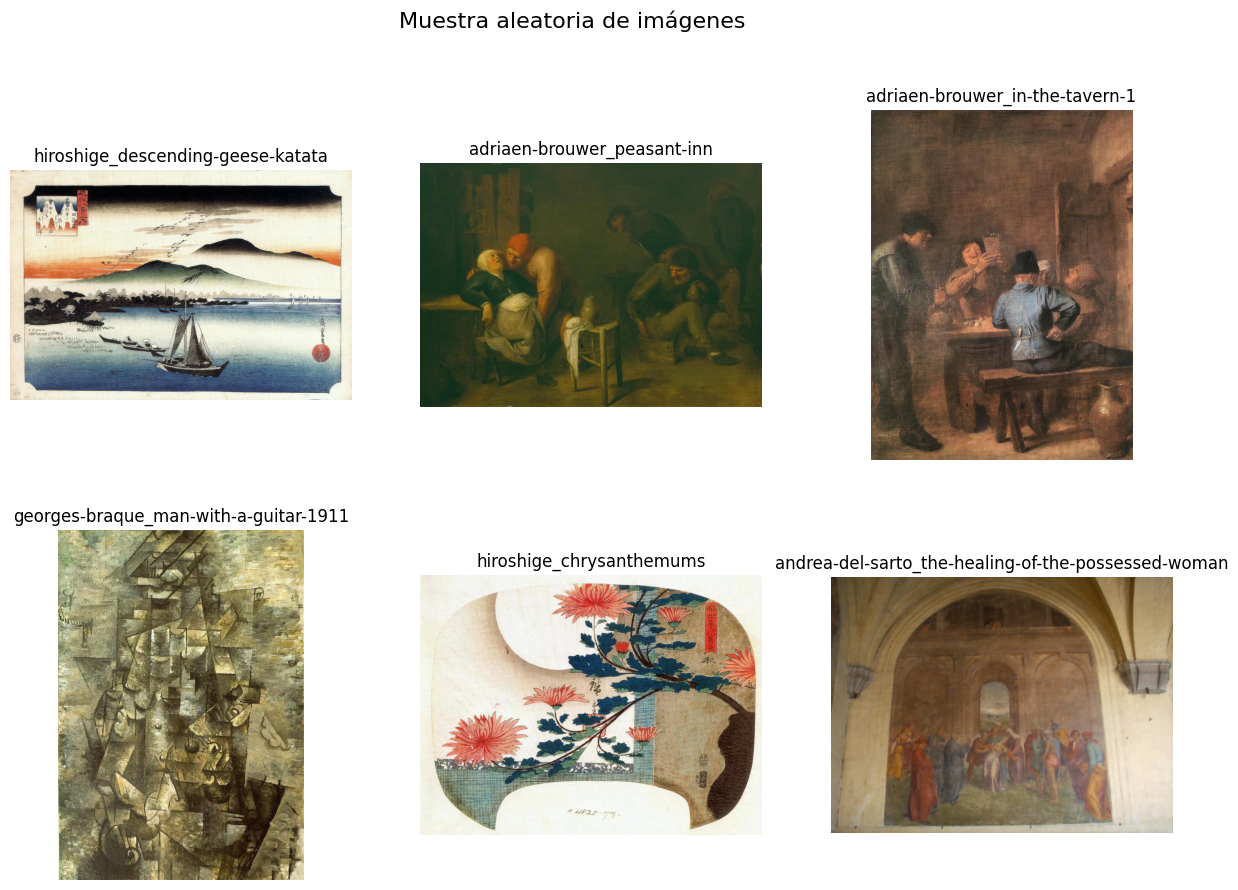

In [3]:
# Listar archivos
image_path = "./Data/"
images_list = get_relative_paths(image_path)
print(f"Número de imágenes en la carpeta: {len(images_list)}")

# 6 imágenes aleatorias
np.random.seed(47)
np.random.shuffle(images_list)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Muestra aleatoria de imágenes", fontsize=16)
for i in range(6):
    img = cv2.imread(images_list[i])
    ax[i//3, i%3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].title.set_text(images_list[i].split("/")[-1].replace(".jpg", ""))
    ax[i//3, i%3].axis('off')


## Modelado

### Preprocesamiento
Para el preprocesamiento de las imágenes se utilizó la librería `PIL` para redimensionar las imágenes a un tamaño de 128x128 píxeles y convertirlas a RGB. Posteriormente, se "aplanan" las imágenes para convertirlas en un arreglo donde cada elemento está dado por pixel x canales de color, finalmente se normalizaron los valores de los píxeles dividiendo entre 255 para tener rangos de 0 a 1.

Ejemplo imagen preprocesada:
[[0.91372549 0.82352941 0.69019608]
 [0.90588235 0.81568627 0.68235294]
 [0.90980392 0.81960784 0.68627451]
 ...
 [0.90980392 0.85882353 0.79215686]
 [0.89019608 0.83137255 0.75294118]
 [0.8745098  0.81176471 0.7254902 ]]


(-0.5, 499.5, 499.5, -0.5)

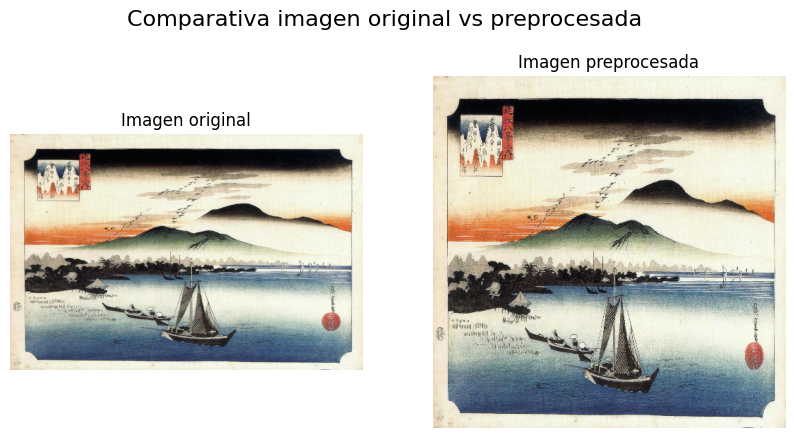

In [4]:
dimension_resize = 500

def preprocesar_imagen(image,dimension_resize=dimension_resize):
    # Convertir a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar
    image = cv2.resize(image, (dimension_resize, dimension_resize))
    # Flatten the image
    image = image.reshape((-1, 3))
    # normalize
    image = image / 255.0
    return image

print("Ejemplo imagen preprocesada:")
print(preprocesar_imagen(cv2.imread(images_list[0])))

# Comparativa imagen original vs preprocesada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Comparativa imagen original vs preprocesada", fontsize=16)
img = cv2.imread(images_list[0])
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].title.set_text("Imagen original")
ax[0].axis('off')
# agregar un reshape dado que la imagen preprocesada es un vector
img = preprocesar_imagen(img).reshape((dimension_resize, dimension_resize, 3))
ax[1].imshow(img)
ax[1].title.set_text("Imagen preprocesada")
ax[1].axis('off')



### Modelos
Dado el contexto del problema, se opta por usar modelos de clustering no supervisado.

Aquí un resumen de algunas ventajas y desventajas de los modelos de clustering más comunes:

| Modelo de clustering                     | Ventajas                                                                                                                                              | Desventajas                                                                                                                                  |
|:-----------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------|
| K-Means                                  | - Simple y eficiente computacionalmente. <br> - Fácil de implementar e interpretar.                                                                   | - Requiere especificar el número de grupos (k) de antemano. <br> - Sensible a la inicialización y puede converger a óptimos locales.             |
|K-Medoids|	- Robusto a outliers. <br> - No se basa en el cálculo de la media (sino escoge prototipos), lo que lo hace útil para datos no euclidianos.|	- Más lento que K-means debido a la necesidad de calcular todas las distancias entre puntos. <br> - Sensible a la elección de los medoids iniciales.|
| Mean Shift                               | - No requiere especificar el número de grupos. <br> - Puede capturar grupos con formas irregulares.                                                   | - Intensivo computacionalmente, especialmente para conjuntos de datos grandes. <br> - Puede converger a soluciones subóptimas.               |
| DBSCAN (Agrupamiento Basado en Densidad) | - Detecta automáticamente el número de grupos. <br> - Robusto al ruido y valores atípicos.                                                            | - Requiere ajustar dos parámetros. <br> - Puede no funcionar bien con grupos de densidades variables.                                        |
| Agrupamiento Jerárquico Aglomerativo     | - Produce una jerarquía de grupos que pueden visualizarse. <br> - No requiere especificar el número de grupos.                                        | - Puede ser computacionalmente costoso. <br> - No es adecuado para conjuntos de datos muy grandes.                                           |
| Modelos de Mezclas Gaussianas (GMM)      | - Enfoque probabilístico que puede capturar grupos superpuestos. <br> - Puede estimar la incertidumbre en las asignaciones de grupos.                 | - Demanda computacionalmente. <br> - Sensible a la inicialización y puede converger a óptimos locales.                                       |
| Mapas Auto-Organizativos (SOM)           | - Produce una representación de baja dimensión de datos de alta dimensión. <br> - Puede preservar las propiedades topológicas del espacio de entrada. | - Requiere ajustar cuidadosamente los parámetros. <br> - Intensivo computacionalmente durante el entrenamiento.                              |
| Agrupamiento Fuzzy C-Means               | - Permite el agrupamiento suave, donde los puntos de datos pueden pertenecer a múltiples grupos con diferentes grados de membresía.                   | - Requiere especificar el número de grupos y un parámetro de difuminación. <br> - Más costoso computacionalmente que K-means.                |



Descarte de modelos:

- **K-Medoids**: Es más lento K-means dado que calcula todas las distancias entre puntos. Al estar basado en prototipos (colores que están realmente en la imagen) y las imágenes tener tanta variedad de colores crearía paletas no muy representativas.
- **Mean Shift**: Intensivo computacionalmente, especialmente para conjuntos de datos grandes(como las imágenes sin resize), no se le especifica el número de grupos, pero se le especifica un radio de búsqueda.
- **DBSCAN**: Requiere ajustar dos parámetros. Puede no funcionar bien con grupos de densidades variables como en el caso de las imágenes de referencia (arte) que pueden tener zonas con muchos colores y otras con pocos.
- **Agrupamiento Jerárquico Aglomerativo**: Puede ser computacionalmente costoso. No es adecuado para conjuntos de datos muy grandes.
- **Mapas Auto-Organizativos (SOM)**: Requiere un trabajo más intensivo al ajustar los parámetros. Intensivo computacionalmente durante el entrenamiento.

Modelos candidatos:

- **K-Means**: Al requerir número de grupos (k) de antemano, lo hace adecuado para el problema dado que esperamos obtener entre 5 a 7 colores, además al basarse en medias, nos puede dar el color representante que agrupa a los demás en la paleta, finalmente es simple y eficiente computacionalmente.
- **Agrupamiento Fuzzy C-Means**: De manera similar a k-means requiere especificar el número de grupos, además de un parámetro de difuminación, lo que lo hace más costoso computacionalmente que K-means.
- **Modelos de Mezclas Gaussianas (GMM)**: Intensivo computacionalmente. Sensible a la inicialización dada, sin embargo, al ser un enfoque probabilístico que puede capturar grupos superpuestos, puede ser útil para el problema dado que esperamos obtener entre 5 a 7 colores.


### Métricas
Para evaluar los modelos de clustering se utilizarán las siguientes métricas:

* Coeficiente de Calinski-Harabasz: Mide la relación entre la dispersión intra-cluster y la dispersión inter-cluster. Un valor más alto indica clusters más densos y separados.

* Coeficiente de Davies-Bouldin: Mide la compacidad de los clusters y la separación entre clusters. Un valor más bajo indica clusters más densos y separados.



### Comparación de modelos
Se compararon los modelos de K-Means, Agrupamiento Fuzzy C-Means y Mezclas Gaussianas, con el fin de seleccionar el modelo que mejor se desempeñe en la generación de paletas de colores, fijando un número de clusters de 7 y parámetros por defecto.



In [13]:
# número de clusters
n_clusters=7

# Pipeline con KMeans
pipeline_k_means = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', KMeans(n_clusters=n_clusters)) # Modelo base
])



# Pipeline con Fuzzy C-Means
# Definir el modelo como una clase
class FuzzyCMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=7, m=2, max_iter=1000, tol=0.005):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.tol = tol
    
    def fit(self, X, y=None):
        self.cluster_centers_, self.u, _, _, _, _, _ = fuzz.cluster.cmeans(X.T, self.n_clusters, self.m, error=self.tol, maxiter=self.max_iter, init=None)
        # las etiquetas serán el cluster con mayor pertenencia
        self.labels_ = np.argmax(self.u, axis=0)
        return self
    


pipeline_fuzzy = pipeline = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', FuzzyCMeansTransformer(n_clusters=n_clusters)) # Modelo base
])


# Pipeline con Modelo de Mezclas de Gaussianas

pipeline_gmm = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', GaussianMixture(n_components=n_clusters)) # Modelo base
])



# Métricas a evaluar
def metricas(X,labels):

    dict_metricas = {
        "calinski_harabasz":calinski_harabasz_score(X, labels), 
        "davies_bouldin":davies_bouldin_score(X, labels)}

    return dict_metricas



Se evalúa cada modelo con un set de 10 imágenes de prueba, se comparan las métricas y se decide sobre la media de las métricas y el tiempo de ejecución.

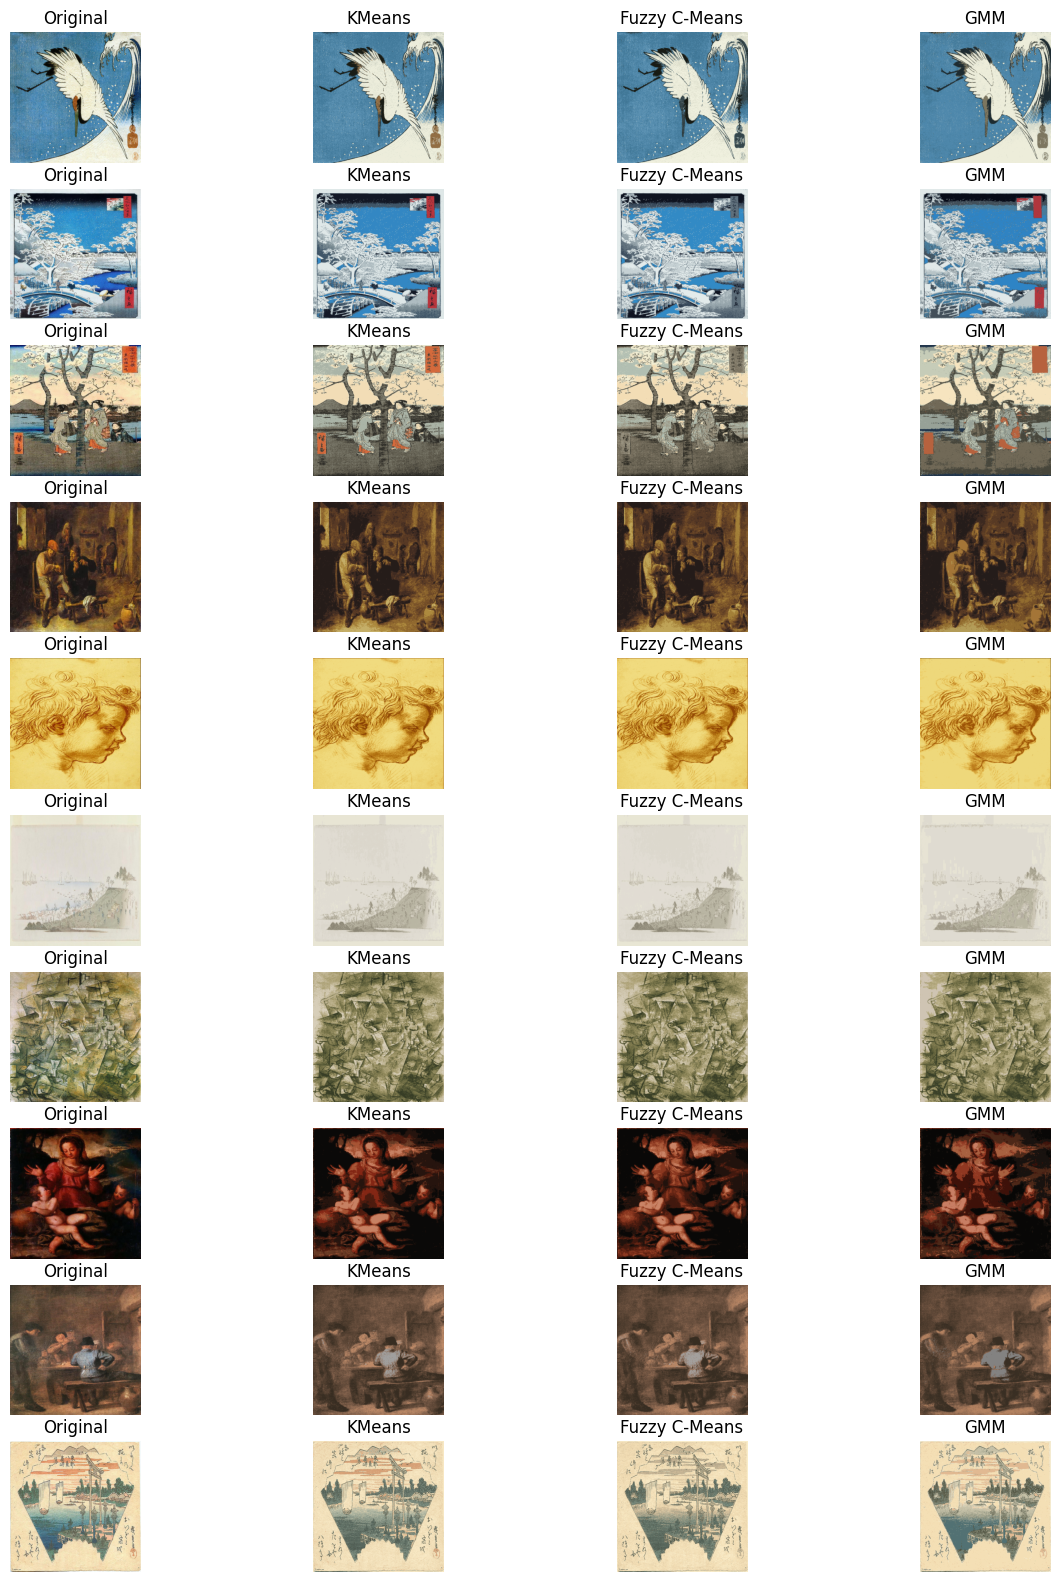

In [15]:
# Seleccionar 10 imágenes aleatorias para evaluar los modelos sin

test_images = random.sample(images_list, 10)

# Evaluar los modelos
modelo, imagen, calinski_harabasz, davies_bouldin, tiempo = [], [], [], [], []
def plot_original_image(ax, img, title='Original',dim = dimension_resize):
    ax.imshow(preprocesar_imagen(img).reshape(dim, dim, 3))
    ax.set_title(title)
    ax.axis('off')


def plot_segmented_image(ax, img, labels, cluster_centers, title, dim=dimension_resize):
    labels = labels.reshape((dim, dim))
    cluster_colors = np.array(cluster_centers)[labels.flatten()]

    segmented_image = cluster_colors.reshape((dim, dim, -1))
    
    # Create a ListedColormap from the cluster centers
    cmap = ListedColormap(cluster_centers)

    im = ax.imshow(segmented_image, cmap=cmap, vmin=0, vmax=len(cluster_centers)-1)
    ax.set_title(f"{title}")
    ax.axis('off')


fig, axs = plt.subplots(len(test_images), 4, figsize=(15, 20))

for i, image in enumerate(test_images):

    image_readed = cv2.imread(image)
    # dato transformado para generar métricas	
    X = pipeline.named_steps['preprocesar_imagen'].transform(image_readed)
    

    # Original
    plot_original_image(axs[i, 0], image_readed)


    # KMeans
    modelo.append("KMeans")
    imagen.append(image.split("/")[-1])

    ## Ajustar el modelo
    inicio = time()
    pipeline_k_means.fit(image_readed)
    fin = time()

    ## Obtener las etiquetas y los centros de los clusters
    labels = pipeline_k_means["cluster"].labels_
    cluster_centers = pipeline_k_means["cluster"].cluster_centers_

    
    ## Calcular métricas
    metricas_modelo = metricas(X,labels)
    calinski_harabasz.append(metricas_modelo["calinski_harabasz"])
    davies_bouldin.append(metricas_modelo["davies_bouldin"])
    tiempo.append(fin - inicio)

    ## Graficar
    plot_segmented_image(axs[i, 1], img, labels, cluster_centers, 'KMeans')


    # Fuzzy C-Means
    modelo.append("Fuzzy C-Means")
    imagen.append(image.split("/")[-1])

    ## Ajustar el modelo
    inicio = time()
    pipeline_fuzzy.fit(image_readed)
    fin = time()
    
    ## Obtener las etiquetas y los centros de los clusters
    labels = pipeline_fuzzy["cluster"].labels_
    cluster_centers = pipeline_fuzzy["cluster"].cluster_centers_

    ## Calcular métricas
    metricas_modelo = metricas(X,labels)
    calinski_harabasz.append(metricas_modelo["calinski_harabasz"])
    davies_bouldin.append(metricas_modelo["davies_bouldin"])
    tiempo.append(fin - inicio)

    ## Graficar
    plot_segmented_image(axs[i, 2], img, labels, cluster_centers, 'Fuzzy C-Means')


    # GMM
    modelo.append("GMM")
    imagen.append(image.split("/")[-1])
    
    ## Ajustar el modelo
    inicio = time()
    pipeline_gmm.fit(image_readed)
    fin = time()
    
    ## Obtener las etiquetas y los centros de los clusters
    labels = pipeline_gmm.predict(image_readed)
    cluster_centers = pipeline_gmm["cluster"].means_

    ## Calcular métricas
    metricas_modelo = metricas(X,labels)
    calinski_harabasz.append(metricas_modelo["calinski_harabasz"])
    davies_bouldin.append(metricas_modelo["davies_bouldin"])
    tiempo.append(fin - inicio)

    ## Graficar
    plot_segmented_image(axs[i, 3], img, labels, cluster_centers, 'GMM')



# Crear un DataFrame con los resultados

resultados_modelos = pd.DataFrame({
    "modelo": modelo,
    "imagen": imagen,
    "calinski_harabasz": calinski_harabasz,
    "davies_bouldin": davies_bouldin,
    "tiempo": tiempo
})



Visualmente no se aprecia mucha diferencia entre los modelos, el único modelo que destaca dado su bajo rendimiento es GMM, mostrando menor definición en los colores, por ejemplo agrupando el color con su sombra.

Por lo cual se evalúa el rendimiento medio de los modelos con las métricas seleccionadas.

In [16]:
resultados_modelos

,modelo,imagen,calinski_harabasz,davies_bouldin,tiempo
0,KMeans,hiroshige_crane-and-wave-1830.jpg,890243.124929,0.787559,0.165969
1,Fuzzy C-Means,hiroshige_crane-and-wave-1830.jpg,753420.040733,0.898519,14.381142
2,GMM,hiroshige_crane-and-wave-1830.jpg,587957.872869,1.016690,3.241215
3,KMeans,hiroshige_drum-bridge-and-setting-sun-hill-meg...,828999.794034,0.611580,0.145999
4,Fuzzy C-Means,hiroshige_drum-bridge-and-setting-sun-hill-meg...,670949.588705,0.821715,17.996220
5,GMM,hiroshige_drum-bridge-and-setting-sun-hill-meg...,365039.284092,0.943929,5.011663
6,KMeans,hiroshige_cherry-tree.jpg,607806.746728,0.801553,0.119996
7,Fuzzy C-Means,hiroshige_cherry-tree.jpg,498511.803106,0.938001,23.212741
8,GMM,hiroshige_cherry-tree.jpg,305218.756671,1.193935,4.140105
9,KMeans,adriaen-brouwer_in-the-tavern.jpg,586520.137582,0.808988,0.137998


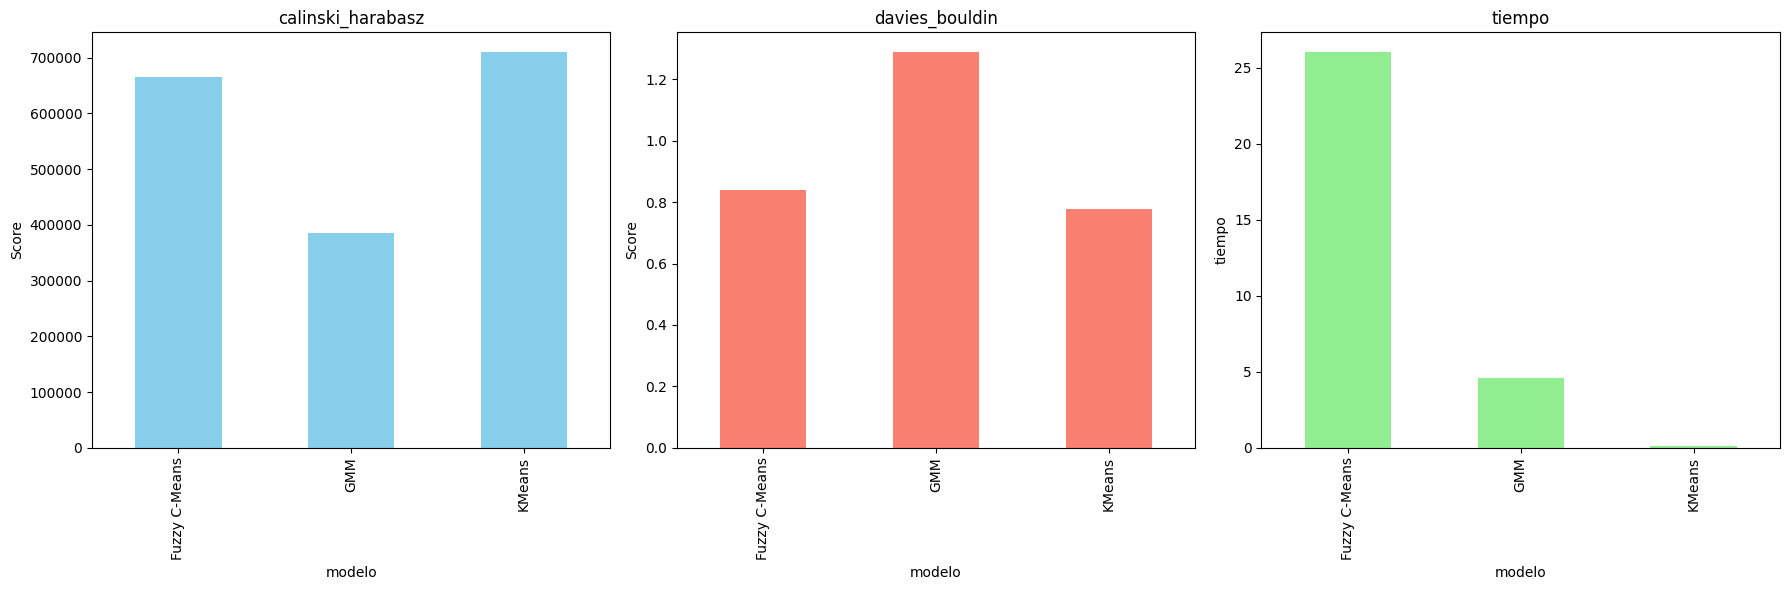

In [17]:
grouped_data = resultados_modelos.groupby('modelo').agg({'calinski_harabasz': 'mean', 'davies_bouldin': 'mean', 'tiempo': 'mean'})

# Comparación de los modelos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calinski-Harabasz plot
grouped_data['calinski_harabasz'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('calinski_harabasz')
axes[0].set_ylabel('Score')

# Davies-Bouldin plot
grouped_data['davies_bouldin'].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('davies_bouldin')
axes[1].set_ylabel('Score')

# Tiempo plot
grouped_data['tiempo'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('tiempo')
axes[2].set_ylabel('tiempo')

plt.tight_layout()
plt.show()

Se puede observar que los mejores modelos son K-Means y Fuzzy C-Means (calinski_harabasz alto y davies_bouldin bajo), sin embargo, K-Means tiene un mejor rendimiento en tiempo de ejecución, por lo que se selecciona K-Means como el modelo a utilizar.

### Estimación de hiperparámetros (pendiente)

In [19]:

# Define scorer functions for Calinski-Harabasz score
def calinski_harabasz(estimator, X):
    X = estimator.named_steps['preprocesar_imagen'].transform(X)
    labels = estimator["cluster"].labels_
    return calinski_harabasz_score(X, labels)


# Define scorer functions for Davies-Bouldin score
def davies_bouldin(estimator, X):
    X = estimator.named_steps['preprocesar_imagen'].transform(X)
    labels = estimator["cluster"].labels_
    return -davies_bouldin_score(X, labels) # negativo para que sea maximización



#### K-means

In [23]:
pipeline = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', KMeans()) # Modelo base
])



param_grid = {
    'cluster': [KMeans()], # Modelos a probar
    'cluster__n_clusters': [5,6,7], # Range of clusters to try
    'cluster__init': ['k-means++', 'random'], # Different initialization strategies
    'cluster__n_init': [10,"auto"], # Number of initializations to try
    'cluster__random_state': [47] # Random state
}


grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                            scoring={
                                    'calinski_harabasz': calinski_harabasz,
                                    'davies_bouldin': davies_bouldin}, 
                           refit='calinski_harabasz')


grid_search.fit(cv2.imread(images_list[0]))

GridSearchCV(estimator=Pipeline(steps=[('preprocesar_imagen',
                                        FunctionTransformer(func=<function preprocesar_imagen at 0x000002709864B060>)),
                                       ('cluster', KMeans())]),
             param_grid={'cluster': [KMeans()],
                         'cluster__init': ['k-means++', 'random'],
                         'cluster__n_clusters': [5, 6, 7],
                         'cluster__n_init': [10, 'auto'],
                         'cluster__random_state': [47]},
             refit='calinski_harabasz',
             scoring={'calinski_harabasz': <function calinski_harabasz at 0x000002709D59DC60>,
                      'davies_bouldin': <function davies_bouldin at 0x000002709D59DBC0>})

### Interfaz

In [128]:
import gradio as gr

def process(image):

    # Creación de paleta
    pipeline_k_means.fit(image)
    cluster_centers = pipeline_k_means["cluster"].cluster_centers_

    show_palette(cluster_centers,"KMeans")

    palette = cv2.imread("./Output/palette.png")

    # # Imagen segmentada
    
    dim = dimension_resize
    labels = pipeline_k_means["cluster"].labels_
    labels = labels.reshape((dim, dim))
    cluster_colors = np.array(cluster_centers)[labels.flatten()]

    segmented_image = cluster_colors.reshape((dim, dim, -1))

    # Create a ListedColormap from the cluster centers
    cmap = ListedColormap(cluster_centers)

    plt.imshow(segmented_image, cmap=cmap, vmin=0, vmax=len(cluster_centers)-1)
    plt.title("Imagen segmentada")
    plt.axis('off')
    # Adjust margins to remove blank space
    plt.margins(0)

    # Get rid of unnecessary padding
    plt.tight_layout()

    save_path = "./Output/segmented_image.png"

    plt.savefig(save_path,bbox_inches='tight')
    plt.close()

    segmented_image = cv2.imread("./Output/segmented_image.png")



    return palette,segmented_image



demo = gr.Interface(
    fn=process,
    inputs=gr.Image(height=500, width=600,label="Imagen"),
    outputs=[gr.Image(height=250, width=600,label="Paleta de colores"),gr.Image(height=500, width=600,label="Imagen segmentada")],
)

demo.launch()


Running on local URL:  http://127.0.0.1:7911

To create a public link, set `share=True` in `launch()`.
